In [1]:
library(igraph)
library(tidygraph)
library(tidyverse)
library(ggrepel)
library(cowplot)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups

The following object is masked from ‘package:stats’:

    filter

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::groups()        masks tidygraph::groups(), igr

In [2]:
# read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
vegas <- read_tsv('../preprocessing/scored_genes.vegas.txt', col_types = 'iciddddddcd') %>%
    select(Gene, `Top-0.1-pvalue`) %>%
    rename(name = Gene, p = `Top-0.1-pvalue`)
ppi <- read_tsv('../preprocessing/hint.ht_complex.hgnc.pseudo.tab2') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
hgnc <- read_tsv('non_alt_loci_set.txt') %>%
    select(symbol, ensembl_gene_id)
# wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gff3.gz
# gzcat gencode.v31.annotation.gff3.gz >gencode.v31.annotation.gff3
gene_types <- read_tsv('gencode.v31.annotation.gff3', comment = '#', col_names = FALSE) %>%
    filter(X3 == 'gene') %>%
    select(X9) %>%
    mutate(X9 = gsub('ID=', '', X9),
           X9 = gsub('\\.[0-9]+;gene_id.+gene_type=', ';', X9),
           X9 = gsub(';gene_name.+', '', X9)) %>%
    separate(X9, into = c('ensembl_gene_id','type'), sep = ';') %>%
    inner_join(hgnc, by = "ensembl_gene_id")

Parsed with column specification:
cols(
  Uniprot_A = col_character(),
  Uniprot_B = col_character(),
  Gene_A = col_character(),
  Gene_B = col_character(),
  ORF_A = col_character(),
  ORF_B = col_character(),
  Alias_A = col_character(),
  Alias_B = col_character(),
  `pmid:method:quality` = col_character(),
  id = col_double(),
  `Official Symbol Interactor A` = col_character(),
  `Official Symbol Interactor B` = col_character()
)
Parsed with column specification:
cols(
  .default = col_character(),
  gene_family = col_logical(),
  gene_family_id = col_logical(),
  date_approved_reserved = col_date(format = ""),
  date_symbol_changed = col_date(format = ""),
  date_name_changed = col_date(format = ""),
  date_modified = col_date(format = ""),
  entrez_id = col_double(),
  mirbase = col_logical(),
  homeodb = col_double(),
  snornabase = col_logical(),
  bioparadigms_slc = col_logical(),
  orphanet = col_double(),
  horde_id = col_logical(),
  imgt = col_logical(),
  kznf_gene_catal

In [3]:
degree_p <- ppi %>%
    mutate(degree = centrality_degree()) %>%
    as_tibble %>%
    full_join(vegas, by = 'name') %>%
    mutate(degree = ifelse(is.na(degree), 1e-1, degree),
           p = ifelse(is.na(p), 1e-7, p))

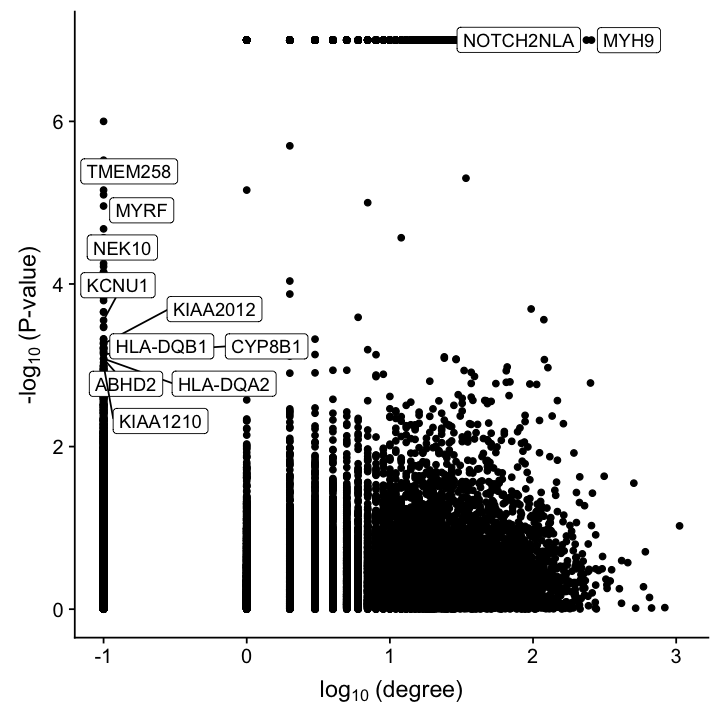

In [4]:
is_protein_coding <- degree_p$name %in% gene_types$symbol[gene_types$type == 'protein_coding']

set.seed(42)

options(repr.plot.width=6, repr.plot.height=6)
ggplot(degree_p, aes(x = log10(degree), y = -log10(p))) +
    geom_point() +
    geom_label_repel(data = filter(degree_p, p < 10e-4 & degree == 0.1 & is_protein_coding), aes(x = log10(degree), y = -log10(p), label = name)) +
    geom_label_repel(data = filter(degree_p, p == 1e-7 & degree > 200), aes(x = log10(degree), y = -log10(p), label = name)) +
    labs(x = bquote('log' [10] ~'(degree)'),
         y = bquote('-log' [10] ~'(P-value)'))

# Genes in the network with no mapped SNPs

In [5]:
genes_icogs <- read_tsv('../preprocessing/snp2hgnc.tsv', col_types = 'cc')$gene %>% unique
genes_hint <- as_tibble(ppi)$name

# genes with no p-value
setdiff(genes_hint, genes_icogs) %>% length
# genes in the network
length(genes_hint)

[1] 928

[1] 13619

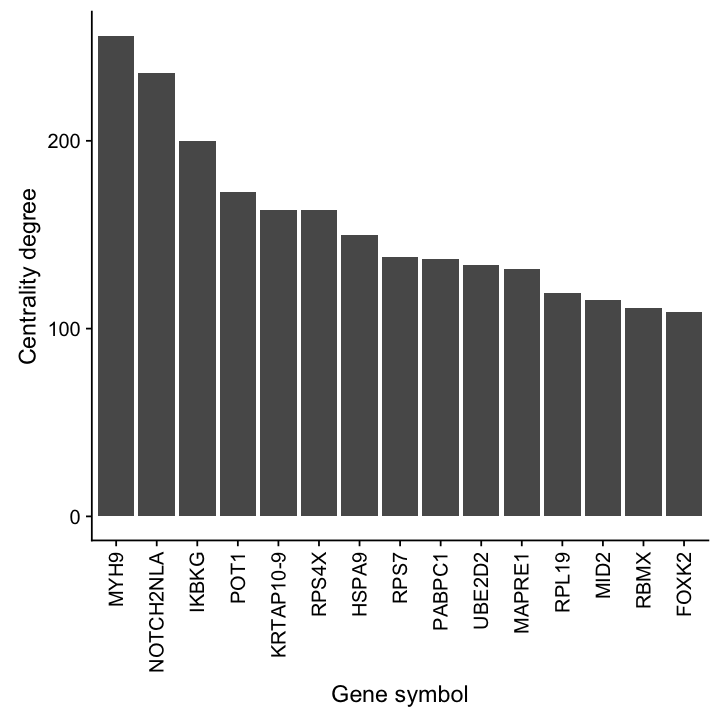

In [6]:
filter(degree_p, ! name %in% genes_icogs) %>%
    arrange(-degree) %>%
    mutate(name = factor(name, levels = name)) %>%
    head(15) %>%
    ggplot(aes(x = name, y = degree)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene symbol', y = 'Centrality degree') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

## Comparison to other chips

## Comparison to iCOGS pre-QC

In [7]:
pre_qc <- read_tsv('snp2gene.preqc.tsv', col_types = 'cc')

In [8]:
genes_pre_qc <- pre_qc$gene %>% unique

# number of genes lost in qc
setdiff(genes_pre_qc, genes_icogs) %>% length

[1] 301

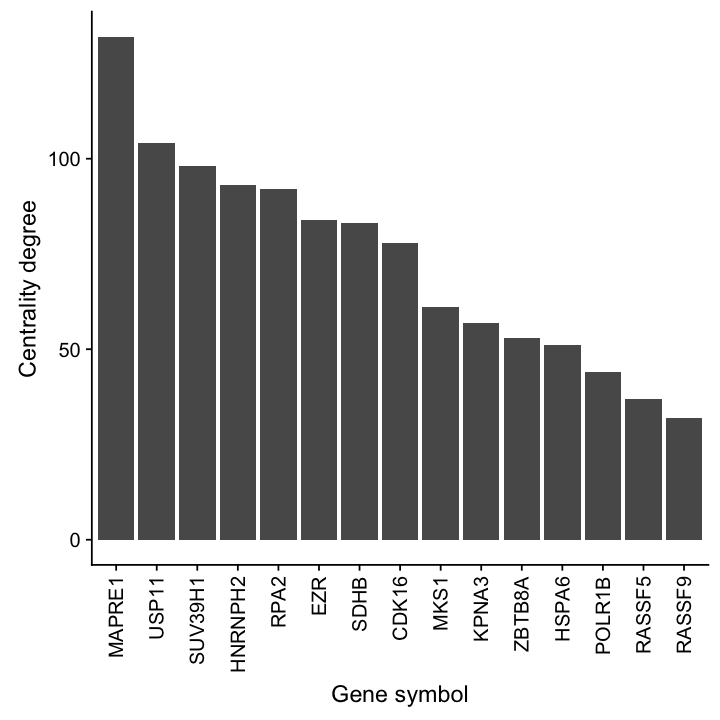

In [9]:
filter(degree_p, name %in% setdiff(genes_pre_qc, genes_icogs)) %>%
    arrange(-degree) %>%
    mutate(name = factor(name, levels = name)) %>%
    head(15) %>%
    ggplot(aes(x = name, y = degree)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene symbol', y = 'Centrality degree') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

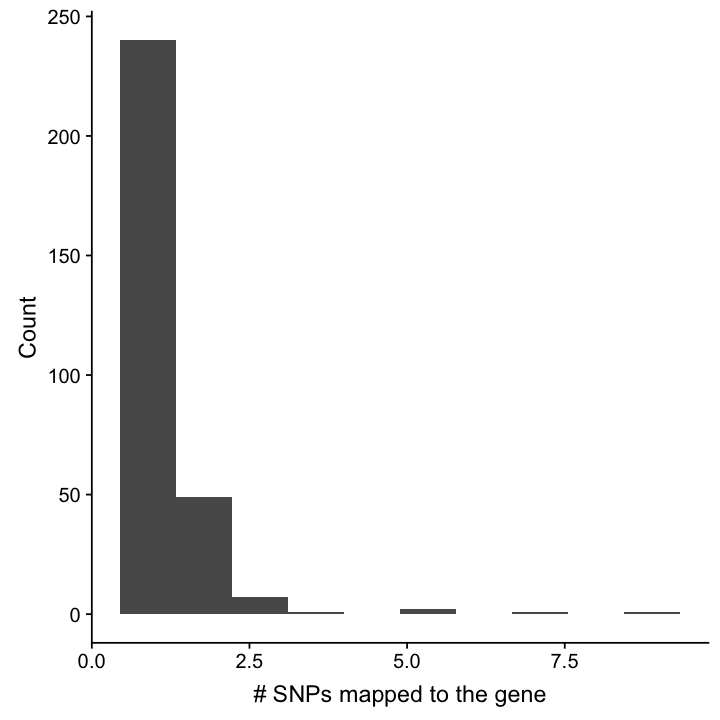

In [10]:
filter(pre_qc, gene %in% setdiff(genes_pre_qc, genes_icogs)) %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = n)) +
        geom_histogram(bins = 10) +
        labs(x = '# SNPs mapped to the gene', y = 'Count')

# Genes with no interactions

In [11]:
# genes with no ppi
setdiff(genes_icogs, genes_hint) %>% length
# genes icogs
length(genes_icogs)

[1] 20441

[1] 33132

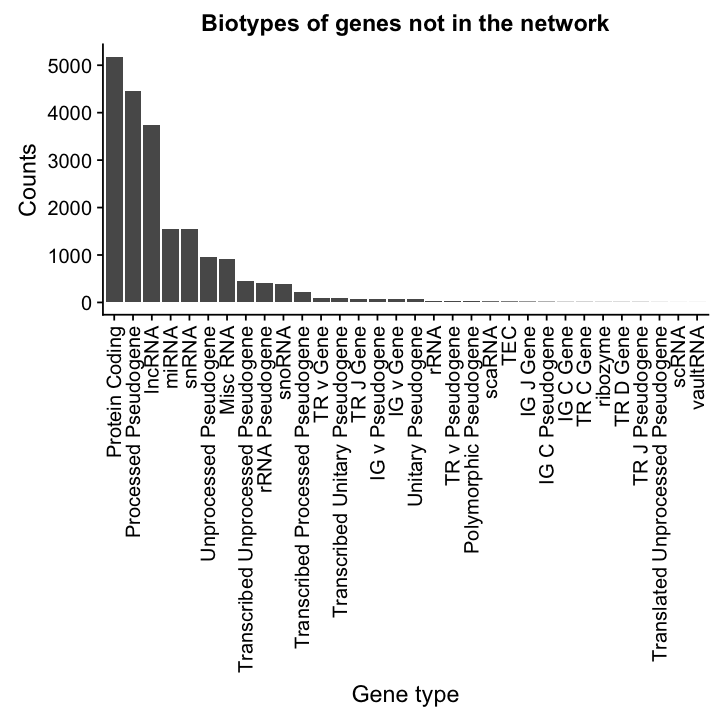

In [12]:
filter(gene_types, symbol %in% setdiff(genes_icogs, genes_hint)) %>%
    mutate(type = gsub('_', ' ', type),
           type = ifelse(grepl(' ', type), tools::toTitleCase(type), type)) %>%
    group_by(type) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(type = factor(type, levels = type)) %>%
    ggplot(aes(x = type, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene type', y = 'Counts', title = 'Biotypes of genes not in the network') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

In [13]:
filter(degree_p, degree == 0.1 & is_protein_coding) %>% nrow

[1] 5184

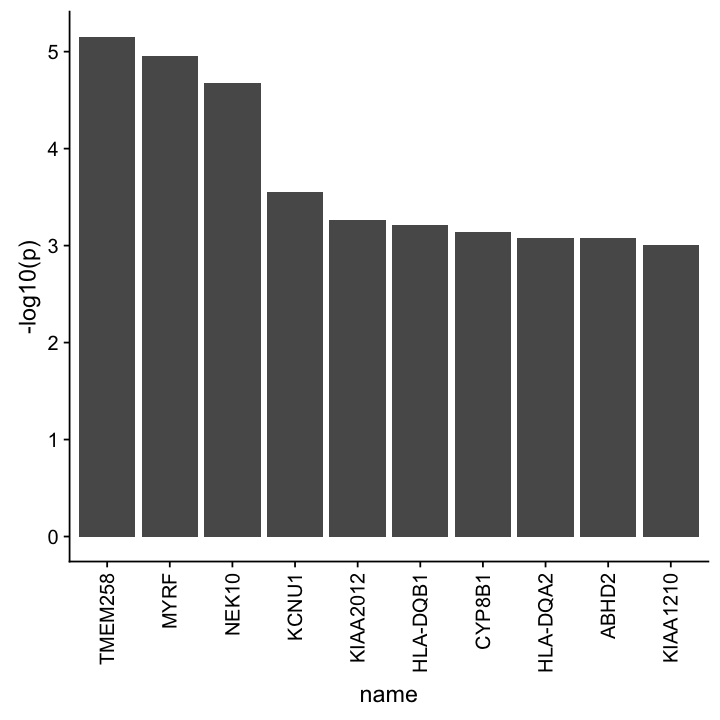

In [14]:
filter(degree_p, degree == 0.1 & is_protein_coding) %>%
    arrange(p) %>%
    mutate(name = factor(name, levels = unique(name))) %>%
    head(10) %>%
    ggplot(aes(name, -log10(p))) +
        geom_bar(stat = 'identity') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

# Rarities

In [15]:
# genes that vegas maps and I do not
filter(degree_p, degree == 0.1) %>%
    filter(! name %in% genes_icogs) %>%
    arrange(p)

name,degree,p
<chr>,<dbl>,<dbl>
SLC5A4,0.1,0.007629924
LY6E,0.1,0.465534466
ASMT,0.1,0.985014985
